In this Jupyer notebook, I create the final Pb dataset to be used for the development of the Pb concentration and isotope composition models.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
pd.set_option('display.max_columns', 500)

## <strong style = "color:green"> Import and clean the GEOTRACES IDP 2021v2 data product </strong>

In [2]:
with open('../../Data/GEOTRACES_IDP2021v2_Seawater.csv', mode='r', newline='') as csvfile:
    IDP2021 = pd.read_csv(csvfile)

/tmp/ipykernel_750919/3146986188.py:2: DtypeWarning: Columns (1,12,21,25,33,35,37,39,41,424) have mixed types. Specify dtype option on import or set low_memory=False.
  IDP2021 = pd.read_csv(csvfile)


##### Change QV:SEADATANET column names to include variable name

In [3]:
df_columns = list(IDP2021.columns) 

for column in df_columns:
    if 'QV:SEADATA' in column:
        idx = IDP2021.columns.get_loc(column)
        IDP2021.rename(columns={IDP2021.columns[idx]: f'QV:{df_columns[idx-1]}'}, inplace = True) 

df_columns = list(IDP2021.columns)
#df_columns    

##### Remove Bio variables

In [4]:
var_to_exclude = ['HPLC', 'PEP', 'NCBI', 'EMBL', 'CELL']

for i in range(0, len(var_to_exclude)):
    IDP2021.drop([col for col in IDP2021.columns if var_to_exclude[i] in col],axis=1,inplace=True)

df_columns = list(IDP2021.columns)    

##### Remove redundant cruise information

In [5]:
var_to_exclude = ['Operator', 'Ship Name', 'Period', 'Chief Scientist', 'GEOTRACES Scientist', 'Cruise Aliases', 'Cruise Information Link', 'BODC Cruise Number']

for i in range(0, len(var_to_exclude)):
    IDP2021.drop([col for col in IDP2021.columns if var_to_exclude[i] in col],axis=1,inplace=True)

df_columns = list(IDP2021.columns)  

##### Remove redundant sampling information

In [6]:
var_to_exclude = ['Rosette Bottle', 'GEOTRACES Sample ID', 'Bottle Flag', 'Cast Identifier', 'BODC Bottle', 'BODC Event', 'Single-Cell ID']

for i in range(0, len(var_to_exclude)):
    IDP2021.drop([col for col in IDP2021.columns if var_to_exclude[i] in col],axis=1,inplace=True)

df_columns = list(IDP2021.columns)  

##### Remove non-Pb columns

In [7]:
info_data = IDP2021.iloc[:, :16]
#info_data

In [8]:
pb_data = IDP2021.filter(like='Pb', axis = 1)
#pb_data

In [9]:
pb_dataset = pd.concat([info_data, pb_data], axis = 1)
pb_dataset

,Cruise,Station:METAVAR:INDEXED_TEXT,Type,yyyy-mm-ddThh:mm:ss.sss,Longitude [degrees_east],Latitude [degrees_north],Bot. Depth [m],CTDPRS_T_VALUE_SENSOR [dbar],QV:CTDPRS_T_VALUE_SENSOR [dbar],DEPTH [m],QV:DEPTH [m],Sampling Device:INDEXED_TEXT,QV:Sampling Device:INDEXED_TEXT,CTDTMP_T_VALUE_SENSOR [deg C],QV:CTDTMP_T_VALUE_SENSOR [deg C],CTDSAL_D_CONC_SENSOR [pss-78],Pb_D_CONC_BOTTLE [pmol/kg],QV:Pb_D_CONC_BOTTLE [pmol/kg],Pb_TD_CONC_BOTTLE [pmol/kg],QV:Pb_TD_CONC_BOTTLE [pmol/kg],Pb_D_CONC_FISH [pmol/kg],QV:Pb_D_CONC_FISH [pmol/kg],Pb_TD_CONC_FISH [pmol/kg],QV:Pb_TD_CONC_FISH [pmol/kg],Pb_D_CONC_BOAT_PUMP [pmol/kg],QV:Pb_D_CONC_BOAT_PUMP [pmol/kg],Pb_D_CONC_SUBICE_PUMP [pmol/kg],QV:Pb_D_CONC_SUBICE_PUMP [pmol/kg],Pb_206_204_D_RATIO_BOTTLE,QV:Pb_206_204_D_RATIO_BOTTLE,Pb_206_204_TD_RATIO_BOTTLE,QV:Pb_206_204_TD_RATIO_BOTTLE,Pb_206_207_D_RATIO_BOTTLE,QV:Pb_206_207_D_RATIO_BOTTLE,Pb_206_207_TD_RATIO_BOTTLE,QV:Pb_206_207_TD_RATIO_BOTTLE,Pb_208_207_D_RATIO_BOTTLE,QV:Pb_208_207_D_RATIO_BOTTLE,Pb_208_207_TD_RATIO_BOTTLE,QV:Pb_208_207_TD_RATIO_BOTTLE,Pb_207_204_TD_RATIO_BOTTLE,QV:Pb_207_204_TD_RATIO_BOTTLE,Pb_208_204_TD_RATIO_BOTTLE,QV:Pb_208_204_TD_RATIO_BOTTLE,Pb_208_206_D_RATIO_BOTTLE,QV:Pb_208_206_D_RATIO_BOTTLE,Pb_208_206_TD_RATIO_BOTTLE,QV:Pb_208_206_TD_RATIO_BOTTLE,Pb_206_204_D_RATIO_FISH,QV:Pb_206_204_D_RATIO_FISH,Pb_206_204_TD_RATIO_FISH,QV:Pb_206_204_TD_RATIO_FISH,Pb_206_207_D_RATIO_FISH,QV:Pb_206_207_D_RATIO_FISH,Pb_206_207_TD_RATIO_FISH,QV:Pb_206_207_TD_RATIO_FISH,Pb_208_207_D_RATIO_FISH,QV:Pb_208_207_D_RATIO_FISH,Pb_208_207_TD_RATIO_FISH,QV:Pb_208_207_TD_RATIO_FISH,Pb_207_204_TD_RATIO_FISH,QV:Pb_207_204_TD_RATIO_FISH,Pb_208_204_TD_RATIO_FISH,QV:Pb_208_204_TD_RATIO_FISH,Pb_208_206_TD_RATIO_FISH,QV:Pb_208_206_TD_RATIO_FISH,Pb_206_204_D_RATIO_BOAT_PUMP,QV:Pb_206_204_D_RATIO_BOAT_PUMP,Pb_206_207_D_RATIO_BOAT_PUMP,QV:Pb_206_207_D_RATIO_BOAT_PUMP,Pb_208_207_D_RATIO_BOAT_PUMP,QV:Pb_208_207_D_RATIO_BOAT_PUMP,Pb_210_D_CONC_BOTTLE [mBq/kg],QV:Pb_210_D_CONC_BOTTLE [mBq/kg],Pb_210_D_CONC_FISH [mBq/kg],QV:Pb_210_D_CONC_FISH [mBq/kg],Pb_210_D_CONC_UWAY [mBq/kg],QV:Pb_210_D_CONC_UWAY [mBq/kg],Pb_TP_CONC_BOTTLE [pmol/kg],QV:Pb_TP_CONC_BOTTLE [pmol/kg],Pb_TPL_CONC_BOTTLE [pmol/kg],QV:Pb_TPL_CONC_BOTTLE [pmol/kg],Pb_TP_CONC_PUMP [pmol/kg],QV:Pb_TP_CONC_PUMP [pmol/kg],Pb_LPT_CONC_PUMP [pmol/kg],QV:Pb_LPT_CONC_PUMP [pmol/kg],Pb_SPT_CONC_PUMP [pmol/kg],QV:Pb_SPT_CONC_PUMP [pmol/kg],Pb_TP_CONC_FISH [pmol/kg],QV:Pb_TP_CONC_FISH [pmol/kg],Pb_TPL_CONC_FISH [pmol/kg],QV:Pb_TPL_CONC_FISH [pmol/kg],Pb_210_TP_CONC_BOTTLE [mBq/kg],QV:Pb_210_TP_CONC_BOTTLE [mBq/kg],Pb_210_SPT_CONC_PUMP [mBq/kg],QV:Pb_210_SPT_CONC_PUMP [mBq/kg],Pb_210_LPT_CONC_PUMP [mBq/kg],QV:Pb_210_LPT_CONC_PUMP [mBq/kg],Pb_210_TP_CONC_UWAY [mBq/kg],QV:Pb_210_TP_CONC_UWAY [mBq/kg]
0,GA01,0,B,2014-05-17T22:29:00,349.29999,38.4329,4854.0,3000.850,0,2957.1,0,UCCTD,0,2.8403,1,34.950802,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9
1,GA01,0,B,2014-05-17T22:29:00,349.29999,38.4329,4854.0,3000.960,0,2957.2,0,UCCTD,0,2.8405,1,34.950699,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9
2,GA01,0,B,2014-05-17T22:29:00,349.29999,38.4329,4854.0,3000.960,0,2957.2,0,UCCTD,0,2.8404,1,34.950802,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9
3,GA01,0,B,2014-05-17T22:29:00,349.29999,38.4329,4854.0,3000.960,0,2957.2,0,UCCTD,0,2.8403,1,34.950802,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9,NaN,9

##### Change flagged values to NaN

In [10]:
df_columns = list(pb_dataset.columns)

for column in df_columns:
    if 'QV:' in column:
        print(column)
        idx = pb_dataset.index[~pb_dataset[column].isin([0, 1, 9])].tolist() #get indices of flagged values
        if len(idx) > 0:
           col = column[3:]
           print(col, ' had ', pb_dataset[col].isnull().sum(), ' null values')
           pb_dataset.loc[idx, col] = pd.NA
           print(col, ' has ', pb_dataset[col].isnull().sum(), ' null values after changing ', len(idx), 'flagged values to NaN') 


QV:CTDPRS_T_VALUE_SENSOR [dbar]
QV:DEPTH [m]
QV:Sampling Device:INDEXED_TEXT
QV:CTDTMP_T_VALUE_SENSOR [deg C]
CTDTMP_T_VALUE_SENSOR [deg C]  had  10652  null values
CTDTMP_T_VALUE_SENSOR [deg C]  has  16815  null values after changing  6163 flagged values to NaN
QV:Pb_D_CONC_BOTTLE [pmol/kg]
Pb_D_CONC_BOTTLE [pmol/kg]  had  94535  null values
Pb_D_CONC_BOTTLE [pmol/kg]  has  96491  null values after changing  1956 flagged values to NaN
QV:Pb_TD_CONC_BOTTLE [pmol/kg]
QV:Pb_D_CONC_FISH [pmol/kg]
QV:Pb_TD_CONC_FISH [pmol/kg]
QV:Pb_D_CONC_BOAT_PUMP [pmol/kg]
QV:Pb_D_CONC_SUBICE_PUMP [pmol/kg]
Pb_D_CONC_SUBICE_PUMP [pmol/kg]  had  105399  null values
Pb_D_CONC_SUBICE_PUMP [pmol/kg]  has  105417  null values after changing  18 flagged values to NaN
QV:Pb_206_204_D_RATIO_BOTTLE
Pb_206_204_D_RATIO_BOTTLE  had  104504  null values
Pb_206_204_D_RATIO_BOTTLE  has  104595  null values after changing  91 flagged values to NaN
QV:Pb_206_204_TD_RATIO_BOTTLE
QV:Pb_206_207_D_RATIO_BOTTLE
Pb_206_207_D_R

##### Drop 'QV:*' columns after changing flagged values

In [11]:
pb_dataset.drop([col for col in pb_dataset.columns if 'QV:' in col],axis=1,inplace=True)
df_columns = list(pb_dataset.columns)
#df_columns

##### Check for empty columns

Get number of observations (not null cells) per variable 

In [12]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(pb_dataset.notnull().sum().sort_values(ascending=True).to_frame())
    #print(IDP2021.notnull().sum().to_frame().sort_index(axis=0)) #alphabetical order

                                      0
Pb_D_CONC_SUBICE_PUMP [pmol/kg]       0
Pb_210_D_CONC_FISH [mBq/kg]           5
Pb_208_207_D_RATIO_BOAT_PUMP          6
Pb_206_207_D_RATIO_BOAT_PUMP          6
Pb_206_204_D_RATIO_BOAT_PUMP          6
Pb_208_206_TD_RATIO_FISH             19
Pb_208_204_TD_RATIO_FISH             19
Pb_D_CONC_BOAT_PUMP [pmol/kg]        19
Pb_207_204_TD_RATIO_FISH             19
Pb_TD_CONC_FISH [pmol/kg]            21
Pb_TPL_CONC_FISH [pmol/kg]           21
Pb_TP_CONC_FISH [pmol/kg]            21
Pb_206_204_D_RATIO_FISH              22
Pb_TP_CONC_PUMP [pmol/kg]            26
Pb_208_207_D_RATIO_FISH              31
Pb_206_207_D_RATIO_FISH              31
Pb_208_207_TD_RATIO_FISH             45
Pb_206_207_TD_RATIO_FISH             45
Pb_206_204_TD_RATIO_FISH             45
Pb_210_TP_CONC_UWAY [mBq/kg]         48
Pb_210_D_CONC_UWAY [mBq/kg]          51
Pb_207_204_TD_RATIO_BOTTLE           60
Pb_208_204_TD_RATIO_BOTTLE           60
Pb_208_206_TD_RATIO_BOTTLE           60


Get percentage of null cells per variable

In [13]:
pb_dataset.isnull().sum().sort_values(ascending=False)/len(pb_dataset)

Pb_D_CONC_SUBICE_PUMP [pmol/kg]    1.000000
Pb_210_D_CONC_FISH [mBq/kg]        0.999953
Pb_206_204_D_RATIO_BOAT_PUMP       0.999943
Pb_206_207_D_RATIO_BOAT_PUMP       0.999943
Pb_208_207_D_RATIO_BOAT_PUMP       0.999943
Pb_D_CONC_BOAT_PUMP [pmol/kg]      0.999820
Pb_207_204_TD_RATIO_FISH           0.999820
Pb_208_206_TD_RATIO_FISH           0.999820
Pb_208_204_TD_RATIO_FISH           0.999820
Pb_TD_CONC_FISH [pmol/kg]          0.999801
Pb_TP_CONC_FISH [pmol/kg]          0.999801
Pb_TPL_CONC_FISH [pmol/kg]         0.999801
Pb_206_204_D_RATIO_FISH            0.999791
Pb_TP_CONC_PUMP [pmol/kg]          0.999753
Pb_206_207_D_RATIO_FISH            0.999706
Pb_208_207_D_RATIO_FISH            0.999706
Pb_206_204_TD_RATIO_FISH           0.999573
Pb_208_207_TD_RATIO_FISH           0.999573
Pb_206_207_TD_RATIO_FISH           0.999573
Pb_210_TP_CONC_UWAY [mBq/kg]       0.999545
Pb_210_D_CONC_UWAY [mBq/kg]        0.999516
Pb_207_204_TD_RATIO_BOTTLE         0.999431
Pb_208_204_TD_RATIO_BOTTLE      

Drop variables that have 100% missing data

In [14]:
missing_values = pb_dataset.isnull().sum().sort_values(ascending=False)/len(pb_dataset)

cols_to_drop = missing_values[missing_values == 1]
cols_to_drop.sort_values(ascending=False)

cols_to_drop = cols_to_drop.index.values

for i in range(0, len(cols_to_drop)):
    pb_dataset.drop([col for col in pb_dataset.columns if cols_to_drop[i] in col],axis=1,inplace=True)

#pb_dataset

##### Keep only rows which include data for at least one Pb variable

In [15]:
pb_dataset.dropna(subset = list(pb_dataset.columns)[12:], how='all', inplace = True)
pb_dataset


,Cruise,Station:METAVAR:INDEXED_TEXT,Type,yyyy-mm-ddThh:mm:ss.sss,Longitude [degrees_east],Latitude [degrees_north],Bot. Depth [m],CTDPRS_T_VALUE_SENSOR [dbar],DEPTH [m],Sampling Device:INDEXED_TEXT,CTDTMP_T_VALUE_SENSOR [deg C],CTDSAL_D_CONC_SENSOR [pss-78],Pb_D_CONC_BOTTLE [pmol/kg],Pb_TD_CONC_BOTTLE [pmol/kg],Pb_D_CONC_FISH [pmol/kg],Pb_TD_CONC_FISH [pmol/kg],Pb_D_CONC_BOAT_PUMP [pmol/kg],Pb_206_204_D_RATIO_BOTTLE,Pb_206_204_TD_RATIO_BOTTLE,Pb_206_207_D_RATIO_BOTTLE,Pb_206_207_TD_RATIO_BOTTLE,Pb_208_207_D_RATIO_BOTTLE,Pb_208_207_TD_RATIO_BOTTLE,Pb_207_204_TD_RATIO_BOTTLE,Pb_208_204_TD_RATIO_BOTTLE,Pb_208_206_D_RATIO_BOTTLE,Pb_208_206_TD_RATIO_BOTTLE,Pb_206_204_D_RATIO_FISH,Pb_206_204_TD_RATIO_FISH,Pb_206_207_D_RATIO_FISH,Pb_206_207_TD_RATIO_FISH,Pb_208_207_D_RATIO_FISH,Pb_208_207_TD_RATIO_FISH,Pb_207_204_TD_RATIO_FISH,Pb_208_204_TD_RATIO_FISH,Pb_208_206_TD_RATIO_FISH,Pb_206_204_D_RATIO_BOAT_PUMP,Pb_206_207_D_RATIO_BOAT_PUMP,Pb_208_207_D_RATIO_BOAT_PUMP,Pb_210_D_CONC_BOTTLE [mBq/kg],Pb_210_D_CONC_FISH [mBq/kg],Pb_210_D_CONC_UWAY [mBq/kg],Pb_TP_CONC_BOTTLE [pmol/kg],Pb_TPL_CONC_BOTTLE [pmol/kg],Pb_TP_CONC_PUMP [pmol/kg],Pb_LPT_CONC_PUMP [pmol/kg],Pb_SPT_CONC_PUMP [pmol/kg],Pb_TP_CONC_FISH [pmol/kg],Pb_TPL_CONC_FISH [pmol/kg],Pb_210_TP_CONC_BOTTLE [mBq/kg],Pb_210_SPT_CONC_PUMP [mBq/kg],Pb_210_LPT_CONC_PUMP [mBq/kg],Pb_210_TP_CONC_UWAY [mBq/kg]
56,GA01,1,B,2014-05-19T18:19:18,349.96399,40.3333,3578.0,19.963,19.8,UCCTD,15.5934,35.341202,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
64,GA01,1,B,2014-05-19T18:19:18,349.96399,40.3333,3578.0,25.206,25.0,SAP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.629705,0.359329,NaN,NaN,NaN,NaN,NaN,NaN
79,GA01,1,B,2014-05-19T18:19:18,349.96399,40.3333,3578.0,40.432,40.1,UCCTD,13.7632,35.689999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99,GA01,1,B,2014-05-19T18:19:18,349.96399,40.3333,3578.0,60.600,60.1,UCCTD,13.3523,35.727501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
106,GA01,1,B,2014-05-19T18:19:18,349.96399,40.3333,3578.0,80.165,79.5,UCCTD,13.1385,35.739101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104964,GS01,(1),B,2018-01-11T10:10:35,146.31000,-44.0171,553.0,73.029,72.4,UCCTD,NaN,NaN,12.027431,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
104965,GS01,(1),B,2018-01-11T10:10:35,146.31000,-44.0171,553.0,98.050,97.2,UCCTD,NaN,NaN,12.179043,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
104976,GS01,(1),B,2018-01-11T10:10:35,146.31000,-44.0171,553.0,148.101,146.8,UCCTD,NaN,NaN,12.970498,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
104981,GS01,(1),B,2018-01-11T10:10:35,146.31000,-44.0171,553.0,198.061,196.3,UCCTD,NaN,NaN,9.999832,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## <strong style = "color:green"> Import additional dataset </strong>

In [16]:
with open('../../Data/Additional_data.csv', mode='r', newline='') as cvsfile:
    additional_dataset = pd.read_csv(cvsfile)
additional_dataset

,Cruise,Station:METAVAR:INDEXED_TEXT,DEPTH [m],Latitude [degrees_north],Longitude [degrees_east],Bot. Depth [m],Pb_D_CONC_BOTTLE [pmol/kg],Pb_206_207_D_RATIO_BOTTLE,Pb_208_207_D_RATIO_BOTTLE,Pb_208_206_D_RATIO_BOTTLE,Pb_D_CONC_FISH [pmol/kg],Pb_206_207_D_RATIO_FISH,Pb_208_206_D_RATIO_FISH,Pb_TD_CONC_BOTTLE [pmol/kg],Pb_206_207_TD_RATIO_BOTTLE,Pb_208_207_TD_RATIO_BOTTLE,Pb_TD_CONC_FISH [pmol/kg],Pb_206_207_TD_RATIO_FISH,Pb_208_207_TD_RATIO_FISH
0,GP15,1,0,56.0,203.0378,96.0,NaN,NaN,NaN,NaN,3.356,1.1524,2.1688,NaN,NaN,NaN,NaN,NaN,NaN
1,GP15,1,20,56.0,203.0378,96.0,3.412000,1.1856,NaN,2.0672,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,GP15,1,30,56.0,203.0378,96.0,11.661000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,GP15,1,40,56.0,203.0378,96.0,3.824000,1.1887,NaN,2.0613,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,GP15,1,50,56.0,203.0378,96.0,5.254000,1.1694,NaN,2.1248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1174,GP06-Chen2023,AND34-C/I1,991,29.4,130.8000,3067.0,22.435605,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1175,GP06-Chen2023,AND34-C/I1,1978,29.4,130.8000,3067.0,14.174477,1.1662,2.4510,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1176,GP06-Chen2023,AND34-C/I1,2467,29.4,130.8000,3067.0,11.169529,1.1680,2.4540,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1177,GP06-Chen2023,AND34-C/I1,41,29.4,130.8000,3067.0,40.600803,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Remove data from GP06, so it can be added with additional data from Chen et al. (2023) which includes both Pb conc and isotopes

In [17]:
idx = pb_dataset.index[pb_dataset['Cruise'] == 'GP06']
pb_dataset.drop(idx, inplace=True)

##### Concatenate IDP2021 and additional dataset

In [18]:
pb_dataset = pd.concat([pb_dataset, additional_dataset], ignore_index= True)
pb_dataset

,Cruise,Station:METAVAR:INDEXED_TEXT,Type,yyyy-mm-ddThh:mm:ss.sss,Longitude [degrees_east],Latitude [degrees_north],Bot. Depth [m],CTDPRS_T_VALUE_SENSOR [dbar],DEPTH [m],Sampling Device:INDEXED_TEXT,CTDTMP_T_VALUE_SENSOR [deg C],CTDSAL_D_CONC_SENSOR [pss-78],Pb_D_CONC_BOTTLE [pmol/kg],Pb_TD_CONC_BOTTLE [pmol/kg],Pb_D_CONC_FISH [pmol/kg],Pb_TD_CONC_FISH [pmol/kg],Pb_D_CONC_BOAT_PUMP [pmol/kg],Pb_206_204_D_RATIO_BOTTLE,Pb_206_204_TD_RATIO_BOTTLE,Pb_206_207_D_RATIO_BOTTLE,Pb_206_207_TD_RATIO_BOTTLE,Pb_208_207_D_RATIO_BOTTLE,Pb_208_207_TD_RATIO_BOTTLE,Pb_207_204_TD_RATIO_BOTTLE,Pb_208_204_TD_RATIO_BOTTLE,Pb_208_206_D_RATIO_BOTTLE,Pb_208_206_TD_RATIO_BOTTLE,Pb_206_204_D_RATIO_FISH,Pb_206_204_TD_RATIO_FISH,Pb_206_207_D_RATIO_FISH,Pb_206_207_TD_RATIO_FISH,Pb_208_207_D_RATIO_FISH,Pb_208_207_TD_RATIO_FISH,Pb_207_204_TD_RATIO_FISH,Pb_208_204_TD_RATIO_FISH,Pb_208_206_TD_RATIO_FISH,Pb_206_204_D_RATIO_BOAT_PUMP,Pb_206_207_D_RATIO_BOAT_PUMP,Pb_208_207_D_RATIO_BOAT_PUMP,Pb_210_D_CONC_BOTTLE [mBq/kg],Pb_210_D_CONC_FISH [mBq/kg],Pb_210_D_CONC_UWAY [mBq/kg],Pb_TP_CONC_BOTTLE [pmol/kg],Pb_TPL_CONC_BOTTLE [pmol/kg],Pb_TP_CONC_PUMP [pmol/kg],Pb_LPT_CONC_PUMP [pmol/kg],Pb_SPT_CONC_PUMP [pmol/kg],Pb_TP_CONC_FISH [pmol/kg],Pb_TPL_CONC_FISH [pmol/kg],Pb_210_TP_CONC_BOTTLE [mBq/kg],Pb_210_SPT_CONC_PUMP [mBq/kg],Pb_210_LPT_CONC_PUMP [mBq/kg],Pb_210_TP_CONC_UWAY [mBq/kg],Pb_208_206_D_RATIO_FISH
0,GA01,1,B,2014-05-19T18:19:18,349.96399,40.3333,3578.0,19.963,19.8,UCCTD,15.5934,35.341202,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,GA01,1,B,2014-05-19T18:19:18,349.96399,40.3333,3578.0,25.206,25.0,SAP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.629705,0.359329,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,GA01,1,B,2014-05-19T18:19:18,349.96399,40.3333,3578.0,40.432,40.1,UCCTD,13.7632,35.689999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,GA01,1,B,2014-05-19T18:19:18,349.96399,40.3333,3578.0,60.600,60.1,UCCTD,13.3523,35.727501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,GA01,1,B,2014-05-19T18:19:18,349.96399,40.3333,3578.0,80.165,79.5,UCCTD,13.1385,35.739101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13579,GP06-Chen2023,AND34-C/I1,NaN,NaN,130.80000,29.4000,3067.0,NaN,991.0,NaN,NaN,NaN,22.435605,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13580,GP06-Chen2023,AND34-C/I1,NaN,NaN,130.80000,29.4000,3067.0,NaN,1978.0,NaN,NaN,NaN,14.174477,NaN,NaN,NaN,NaN,NaN,NaN,1.1662,NaN,2.4510,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13581,GP06-Chen2023,AND34-C/I1,NaN,NaN,130.80000,29.4000,3067.0,NaN,2467.0,NaN,NaN,NaN,11.169529,NaN,NaN,NaN,NaN,NaN,NaN,1.1680,NaN,2.4540,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13582,GP06-Chen2023,AND34-C/I1,NaN,NaN,130.80000,29.4000,3067.0,NaN,41.0,NaN,NaN,NaN,40.600803,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Assign closest WOD depth value to each sample depth

Drop observations where 'DEPTH [m]' > 5500 m (WOD limit)

In [19]:
pb_dataset.drop(pb_dataset[pb_dataset['DEPTH [m]'] > 5500].index, inplace = True)
pb_dataset

,Cruise,Station:METAVAR:INDEXED_TEXT,Type,yyyy-mm-ddThh:mm:ss.sss,Longitude [degrees_east],Latitude [degrees_north],Bot. Depth [m],CTDPRS_T_VALUE_SENSOR [dbar],DEPTH [m],Sampling Device:INDEXED_TEXT,CTDTMP_T_VALUE_SENSOR [deg C],CTDSAL_D_CONC_SENSOR [pss-78],Pb_D_CONC_BOTTLE [pmol/kg],Pb_TD_CONC_BOTTLE [pmol/kg],Pb_D_CONC_FISH [pmol/kg],Pb_TD_CONC_FISH [pmol/kg],Pb_D_CONC_BOAT_PUMP [pmol/kg],Pb_206_204_D_RATIO_BOTTLE,Pb_206_204_TD_RATIO_BOTTLE,Pb_206_207_D_RATIO_BOTTLE,Pb_206_207_TD_RATIO_BOTTLE,Pb_208_207_D_RATIO_BOTTLE,Pb_208_207_TD_RATIO_BOTTLE,Pb_207_204_TD_RATIO_BOTTLE,Pb_208_204_TD_RATIO_BOTTLE,Pb_208_206_D_RATIO_BOTTLE,Pb_208_206_TD_RATIO_BOTTLE,Pb_206_204_D_RATIO_FISH,Pb_206_204_TD_RATIO_FISH,Pb_206_207_D_RATIO_FISH,Pb_206_207_TD_RATIO_FISH,Pb_208_207_D_RATIO_FISH,Pb_208_207_TD_RATIO_FISH,Pb_207_204_TD_RATIO_FISH,Pb_208_204_TD_RATIO_FISH,Pb_208_206_TD_RATIO_FISH,Pb_206_204_D_RATIO_BOAT_PUMP,Pb_206_207_D_RATIO_BOAT_PUMP,Pb_208_207_D_RATIO_BOAT_PUMP,Pb_210_D_CONC_BOTTLE [mBq/kg],Pb_210_D_CONC_FISH [mBq/kg],Pb_210_D_CONC_UWAY [mBq/kg],Pb_TP_CONC_BOTTLE [pmol/kg],Pb_TPL_CONC_BOTTLE [pmol/kg],Pb_TP_CONC_PUMP [pmol/kg],Pb_LPT_CONC_PUMP [pmol/kg],Pb_SPT_CONC_PUMP [pmol/kg],Pb_TP_CONC_FISH [pmol/kg],Pb_TPL_CONC_FISH [pmol/kg],Pb_210_TP_CONC_BOTTLE [mBq/kg],Pb_210_SPT_CONC_PUMP [mBq/kg],Pb_210_LPT_CONC_PUMP [mBq/kg],Pb_210_TP_CONC_UWAY [mBq/kg],Pb_208_206_D_RATIO_FISH
0,GA01,1,B,2014-05-19T18:19:18,349.96399,40.3333,3578.0,19.963,19.8,UCCTD,15.5934,35.341202,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,GA01,1,B,2014-05-19T18:19:18,349.96399,40.3333,3578.0,25.206,25.0,SAP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.629705,0.359329,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,GA01,1,B,2014-05-19T18:19:18,349.96399,40.3333,3578.0,40.432,40.1,UCCTD,13.7632,35.689999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,GA01,1,B,2014-05-19T18:19:18,349.96399,40.3333,3578.0,60.600,60.1,UCCTD,13.3523,35.727501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,GA01,1,B,2014-05-19T18:19:18,349.96399,40.3333,3578.0,80.165,79.5,UCCTD,13.1385,35.739101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13579,GP06-Chen2023,AND34-C/I1,NaN,NaN,130.80000,29.4000,3067.0,NaN,991.0,NaN,NaN,NaN,22.435605,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13580,GP06-Chen2023,AND34-C/I1,NaN,NaN,130.80000,29.4000,3067.0,NaN,1978.0,NaN,NaN,NaN,14.174477,NaN,NaN,NaN,NaN,NaN,NaN,1.1662,NaN,2.4510,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13581,GP06-Chen2023,AND34-C/I1,NaN,NaN,130.80000,29.4000,3067.0,NaN,2467.0,NaN,NaN,NaN,11.169529,NaN,NaN,NaN,NaN,NaN,NaN,1.1680,NaN,2.4540,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13582,GP06-Chen2023,AND34-C/I1,NaN,NaN,130.80000,29.4000,3067.0,NaN,41.0,NaN,NaN,NaN,40.600803,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
WOD_depths = []

intervals = [5, 25, 50, 100]

for interval in intervals:
    if interval == 5:
        depths = np.arange(0, 105, interval)
        WOD_depths.extend(list(depths))
    if interval == 25:
        depths = np.arange(125, 525, interval)
        WOD_depths.extend(list(depths))
    if interval == 50:
        depths = np.arange(550, 2050, interval)
        WOD_depths.extend(list(depths))
    if interval == 100:
        depths = np.arange(2100, 5600, interval)
        WOD_depths.extend(list(depths))


In [21]:
depths = pb_dataset['DEPTH [m]']
bottom_depths = pb_dataset['Bot. Depth [m]']
WOD_depths_arr = np.array(WOD_depths)
WOD_depths_l = []

for depth, bottom_depth in zip(depths, bottom_depths):
    WOD_depth = WOD_depths_arr[np.argmin(np.abs(WOD_depths_arr - depth))]
    if WOD_depth > bottom_depth:
        WOD_depth_adj = WOD_depths_arr[(np.argmax(WOD_depths_arr > bottom_depth)) - 1]
        #print(bottom_depth, WOD_depth, WOD_depth_adj)
        WOD_depths_l.append(WOD_depth_adj)
    else:    
        WOD_depths_l.append(WOD_depth)

pb_dataset['WOD_depth'] = WOD_depths_l

##### Assign WOD lat and long to observations

In [22]:
wod_lat = np.arange(-77.5, 90.5, 1) #1-degree spaced latitudes from -77.5N to 89.5N
wod_lon = np.arange(-179.5, 180.5, 1) #1-degree spaced longitudes from -179.5E to 179.5E

obs_lats = pb_dataset['Latitude [degrees_north]']
wod_lat_l = []

for obs_lat in obs_lats:
    wod_lat_l.append(wod_lat[np.argmin(np.abs(wod_lat - obs_lat))])

pb_dataset['WOD_latitude [degrees_north]'] = wod_lat_l

In [23]:
condition = (pb_dataset['Longitude [degrees_east]'] >= 180)
pb_dataset.loc[condition, 'Longitude [degrees_east]'] = pb_dataset['Longitude [degrees_east]'] - 360 

obs_lons = pb_dataset['Longitude [degrees_east]']
wod_lon_l = []

for obs_lon in obs_lons:
    wod_lon_l.append(wod_lon[np.argmin(np.abs(wod_lon - obs_lon))])

pb_dataset['WOD_longitude [degrees_east]'] = wod_lon_l


##### Count number of sampling locations with both TD and D values


Concentration

In [24]:
variables = ['CONC_BOTTLE [pmol/kg]', 'CONC_FISH [pmol/kg]']
samples = ['Pb_TD_', 'Pb_D_']

for variable in variables:
    data = pb_dataset[(pb_dataset[str(samples[0] + variable)].notnull()) & (pb_dataset[str(samples[1] + variable)].notnull())]
    print(f'There are {data.shape[0]} occurrences of corresponding TD and D {variable} sampling locations')

for sample in samples:
    data = pb_dataset[(pb_dataset[str(sample + variables[0])].notnull()) & (pb_dataset[str(sample + variables[1])].notnull())]
    print(f'There are {data.shape[0]} occurrences of corresponding BOTTLE and FISH {sample} sampling locations')

There are 0 occurrences of corresponding TD and D CONC_BOTTLE [pmol/kg] sampling locations
There are 0 occurrences of corresponding TD and D CONC_FISH [pmol/kg] sampling locations
There are 0 occurrences of corresponding BOTTLE and FISH Pb_TD_ sampling locations
There are 0 occurrences of corresponding BOTTLE and FISH Pb_D_ sampling locations


Isotopes

In [25]:
ratios = ['Pb_206_204_', 'Pb_206_207_', 'Pb_208_207_', 'Pb_208_206_',]
samples = ['TD_RATIO_', 'D_RATIO_']
systems = ['BOTTLE', 'FISH']

for ratio in ratios:
    for system in systems:
        data = pb_dataset[(pb_dataset[str(ratio + samples[0] + system)].notnull()) & (pb_dataset[str(ratio + samples[1] + system)].notnull())]
        print(f'There are {data.shape[0]} occurrences of corresponding TD and D {str(ratio + system)} sampling locations')

for ratio in ratios:
    for sample in samples:
        data = pb_dataset[(pb_dataset[str(ratio + sample + systems[0])].notnull()) & (pb_dataset[str(ratio + sample + systems[1])].notnull())]
        print(f'There are {data.shape[0]} occurrences of corresponding FISH and BOTTLE {str(ratio + sample)} sampling locations')

There are 0 occurrences of corresponding TD and D Pb_206_204_BOTTLE sampling locations
There are 0 occurrences of corresponding TD and D Pb_206_204_FISH sampling locations
There are 0 occurrences of corresponding TD and D Pb_206_207_BOTTLE sampling locations
There are 0 occurrences of corresponding TD and D Pb_206_207_FISH sampling locations
There are 0 occurrences of corresponding TD and D Pb_208_207_BOTTLE sampling locations
There are 0 occurrences of corresponding TD and D Pb_208_207_FISH sampling locations
There are 0 occurrences of corresponding TD and D Pb_208_206_BOTTLE sampling locations
There are 0 occurrences of corresponding TD and D Pb_208_206_FISH sampling locations
There are 0 occurrences of corresponding FISH and BOTTLE Pb_206_204_TD_RATIO_ sampling locations
There are 1 occurrences of corresponding FISH and BOTTLE Pb_206_204_D_RATIO_ sampling locations
There are 0 occurrences of corresponding FISH and BOTTLE Pb_206_207_TD_RATIO_ sampling locations
There are 0 occurrence

##### Combine TD & D + BOTTLE & FISH observations in a single column

In [26]:
#something is wrong when combining the 206/204 columns because two values seem to add up - investigate further. We can also just use 206/207 and 208/207 but there seems to be a bug in the code somewhere

pb_dataset['Pb_CONC [pmol/kg]'] = pb_dataset[['Pb_D_CONC_BOTTLE [pmol/kg]', 'Pb_D_CONC_FISH [pmol/kg]', 'Pb_TD_CONC_BOTTLE [pmol/kg]', 'Pb_TD_CONC_FISH [pmol/kg]']].sum(axis = 1, min_count = 1)

ratios = ['Pb_206_207', 'Pb_208_207', 'Pb_208_206',]

for ratio in ratios:
    pb_dataset[ratio] = pb_dataset[[str(ratio + '_D_RATIO_BOTTLE'), str(ratio + '_D_RATIO_FISH'), str(ratio + '_TD_RATIO_BOTTLE'), str(ratio + '_TD_RATIO_FISH')]].sum(axis = 1, min_count = 1)

##### Convert 208_206 ratios to to 208_207

In [27]:
condition = (pb_dataset['Pb_208_207'].isnull())
pb_dataset.loc[condition, 'Pb_208_207'] = pb_dataset['Pb_206_207'] * pb_dataset['Pb_208_206']
pb_dataset['Pb_208_207'].describe()

count    2188.000000
mean        2.446962
std         0.053574
min         0.000000
25%         2.444299
50%         2.449053
75%         2.453200
max         2.551576
Name: Pb_208_207, dtype: float64

In [28]:
pb_dataset.drop(pb_dataset[pb_dataset['Pb_208_207'] < 1].index, inplace = True)
pb_dataset

,Cruise,Station:METAVAR:INDEXED_TEXT,Type,yyyy-mm-ddThh:mm:ss.sss,Longitude [degrees_east],Latitude [degrees_north],Bot. Depth [m],CTDPRS_T_VALUE_SENSOR [dbar],DEPTH [m],Sampling Device:INDEXED_TEXT,CTDTMP_T_VALUE_SENSOR [deg C],CTDSAL_D_CONC_SENSOR [pss-78],Pb_D_CONC_BOTTLE [pmol/kg],Pb_TD_CONC_BOTTLE [pmol/kg],Pb_D_CONC_FISH [pmol/kg],Pb_TD_CONC_FISH [pmol/kg],Pb_D_CONC_BOAT_PUMP [pmol/kg],Pb_206_204_D_RATIO_BOTTLE,Pb_206_204_TD_RATIO_BOTTLE,Pb_206_207_D_RATIO_BOTTLE,Pb_206_207_TD_RATIO_BOTTLE,Pb_208_207_D_RATIO_BOTTLE,Pb_208_207_TD_RATIO_BOTTLE,Pb_207_204_TD_RATIO_BOTTLE,Pb_208_204_TD_RATIO_BOTTLE,Pb_208_206_D_RATIO_BOTTLE,Pb_208_206_TD_RATIO_BOTTLE,Pb_206_204_D_RATIO_FISH,Pb_206_204_TD_RATIO_FISH,Pb_206_207_D_RATIO_FISH,Pb_206_207_TD_RATIO_FISH,Pb_208_207_D_RATIO_FISH,Pb_208_207_TD_RATIO_FISH,Pb_207_204_TD_RATIO_FISH,Pb_208_204_TD_RATIO_FISH,Pb_208_206_TD_RATIO_FISH,Pb_206_204_D_RATIO_BOAT_PUMP,Pb_206_207_D_RATIO_BOAT_PUMP,Pb_208_207_D_RATIO_BOAT_PUMP,Pb_210_D_CONC_BOTTLE [mBq/kg],Pb_210_D_CONC_FISH [mBq/kg],Pb_210_D_CONC_UWAY [mBq/kg],Pb_TP_CONC_BOTTLE [pmol/kg],Pb_TPL_CONC_BOTTLE [pmol/kg],Pb_TP_CONC_PUMP [pmol/kg],Pb_LPT_CONC_PUMP [pmol/kg],Pb_SPT_CONC_PUMP [pmol/kg],Pb_TP_CONC_FISH [pmol/kg],Pb_TPL_CONC_FISH [pmol/kg],Pb_210_TP_CONC_BOTTLE [mBq/kg],Pb_210_SPT_CONC_PUMP [mBq/kg],Pb_210_LPT_CONC_PUMP [mBq/kg],Pb_210_TP_CONC_UWAY [mBq/kg],Pb_208_206_D_RATIO_FISH,WOD_depth,WOD_latitude [degrees_north],WOD_longitude [degrees_east],Pb_CONC [pmol/kg],Pb_206_207,Pb_208_207,Pb_208_206
0,GA01,1,B,2014-05-19T18:19:18,-10.03601,40.3333,3578.0,19.963,19.8,UCCTD,15.5934,35.341202,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20,40.5,-10.5,NaN,NaN,NaN,NaN
1,GA01,1,B,2014-05-19T18:19:18,-10.03601,40.3333,3578.0,25.206,25.0,SAP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.629705,0.359329,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25,40.5,-10.5,NaN,NaN,NaN,NaN
2,GA01,1,B,2014-05-19T18:19:18,-10.03601,40.3333,3578.0,40.432,40.1,UCCTD,13.7632,35.689999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40,40.5,-10.5,NaN,NaN,NaN,NaN
3,GA01,1,B,2014-05-19T18:19:18,-10.03601,40.3333,3578.0,60.600,60.1,UCCTD,13.3523,35.727501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60,40.5,-10.5,NaN,NaN,NaN,NaN
4,GA01,1,B,2014-05-19T18:19:18,-10.03601,40.3333,3578.0,80.165,79.5,UCCTD,13.1385,35.739101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80,40.5,-10.5,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13579,GP06-Chen2023,AND34-C/I1,NaN,NaN,130.80000,29.4000,3067.0,NaN,991.0,NaN,NaN,NaN,22.435605,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000,29.5,130.5,22.435605,NaN,NaN,NaN
13580,GP06-Chen2023,AND34-C/I1,NaN,NaN,130.80000,29.4000,3067.0,NaN,1978.0,NaN,NaN,NaN,14.174477,NaN,NaN,NaN,NaN,NaN,NaN,1.1662,NaN,2.4510,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000,29.5,130.5,14.174477,1.1662,2.4510,NaN
13581,GP06-Chen2023,AND34-C/I1,NaN,NaN,130.80000,29.4000,3067.0,NaN,2467.0,NaN,NaN,NaN,11.169529,NaN,NaN,NaN,NaN,NaN,NaN,1.1680,NaN,2.4540,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

##### Plot Pb conc and ratios

In [29]:
pb_variables = ['Pb_CONC [pmol/kg]', 'Pb_206_207', 'Pb_208_207']

Surface

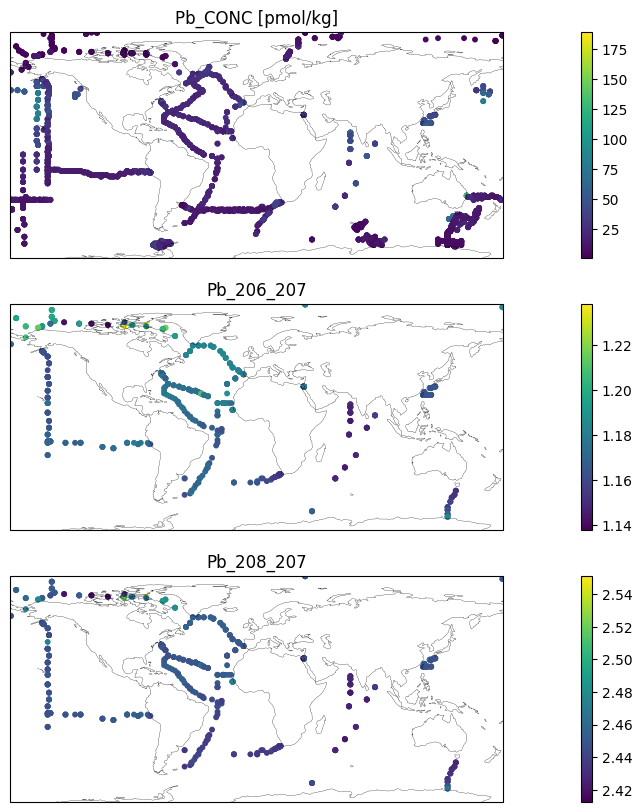

In [30]:
surface_data = pb_dataset[(pb_dataset['WOD_depth'] <= 100)]

proj = ccrs.PlateCarree()
fig,axes = plt.subplots(
    round(len(pb_variables)), 1, figsize=(20, 10), sharex=True, sharey=True,
    subplot_kw={'projection': proj, "aspect": 1},
    gridspec_kw = {'wspace':0.0002, 'hspace':0.2})

for i, ax in zip(range(len(pb_variables)), axes.ravel()):
# (or) for i, ax in enumerate(axes.flat):
    ax.coastlines(lw=0.2)
    sc = ax.scatter(surface_data[surface_data[pb_variables[i]] > 0]['WOD_longitude [degrees_east]'], surface_data[surface_data[pb_variables[i]] > 0]['WOD_latitude [degrees_north]'], c = surface_data[surface_data[pb_variables[i]] > 0][pb_variables[i]], cmap = 'viridis', linewidth=2, marker='o', s = 5)
    plt.colorbar(sc)
    ax.title.set_text(pb_variables[i])

plt.show()


Intermediate

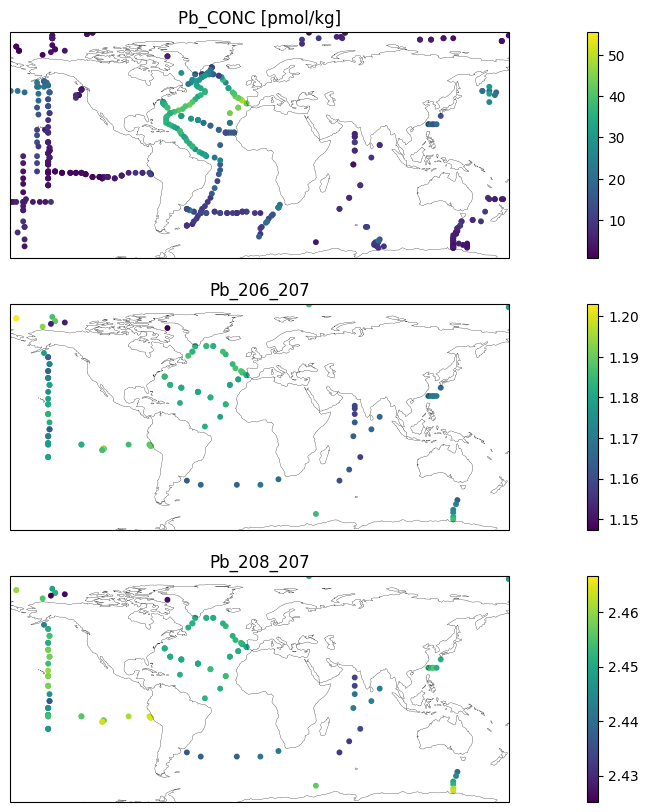

In [31]:
intermediate_data = pb_dataset[pb_dataset['WOD_depth'].between(1800, 2200)]

proj = ccrs.PlateCarree()
fig,axes = plt.subplots(
    round(len(pb_variables)), 1, figsize=(20, 10), sharex=True, sharey=True,
    subplot_kw={'projection': proj, "aspect": 1},
    gridspec_kw = {'wspace':0.0002, 'hspace':0.2})

for i, ax in zip(range(len(pb_variables)), axes.ravel()):
# (or) for i, ax in enumerate(axes.flat):
    ax.coastlines(lw=0.2)
    sc = ax.scatter(intermediate_data[intermediate_data[pb_variables[i]] > 0]['WOD_longitude [degrees_east]'], intermediate_data[intermediate_data[pb_variables[i]] > 0]['WOD_latitude [degrees_north]'], c = intermediate_data[intermediate_data[pb_variables[i]] > 0][pb_variables[i]], cmap = 'viridis', linewidth=2, marker='o', s = 5)
    plt.colorbar(sc)
    ax.title.set_text(pb_variables[i])

plt.show()

Deep

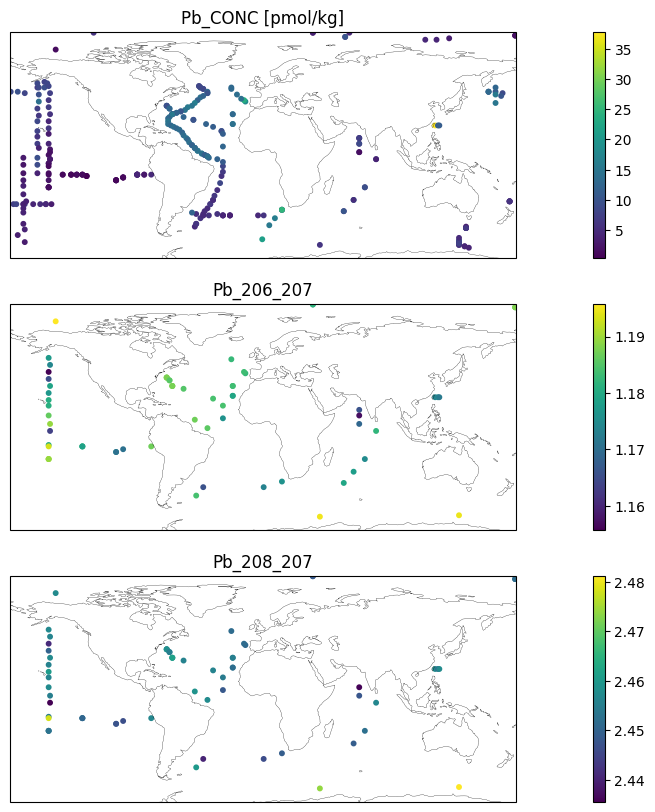

In [32]:
deep_data = pb_dataset[pb_dataset['WOD_depth'].between(3800, 4200)]

proj = ccrs.PlateCarree()
fig,axes = plt.subplots(
    round(len(pb_variables)), 1, figsize=(20, 10), sharex=True, sharey=True,
    subplot_kw={'projection': proj, "aspect": 1},
    gridspec_kw = {'wspace':0.0002, 'hspace':0.2})

for i, ax in zip(range(len(pb_variables)), axes.ravel()):
# (or) for i, ax in enumerate(axes.flat):
    ax.coastlines(lw=0.2)
    sc = ax.scatter(deep_data[deep_data[pb_variables[i]] > 0]['WOD_longitude [degrees_east]'], deep_data[deep_data[pb_variables[i]] > 0]['WOD_latitude [degrees_north]'], c = deep_data[deep_data[pb_variables[i]] > 0][pb_variables[i]], cmap = 'viridis', linewidth=2, marker='o', s = 5)
    plt.colorbar(sc)
    ax.title.set_text(pb_variables[i])

plt.show()

##### Final Pb dataset

In [33]:
WOD_pb_dataset = pb_dataset[['Cruise', 'WOD_depth', 'WOD_latitude [degrees_north]', 'WOD_longitude [degrees_east]', 'Latitude [degrees_north]', 'Longitude [degrees_east]', 'Bot. Depth [m]', 'CTDTMP_T_VALUE_SENSOR [deg C]',
       'CTDSAL_D_CONC_SENSOR [pss-78]', 'Pb_CONC [pmol/kg]', 'Pb_206_207', 'Pb_208_207']]
WOD_pb_dataset.dropna(subset=list(WOD_pb_dataset.columns)[5:], how='all', inplace = True)
WOD_pb_dataset.isnull().sum()
#WOD_pb_dataset

/tmp/ipykernel_750919/1825471941.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WOD_pb_dataset.dropna(subset=list(WOD_pb_dataset.columns)[5:], how='all', inplace = True)


Cruise                               0
WOD_depth                            0
WOD_latitude [degrees_north]         0
WOD_longitude [degrees_east]         0
Latitude [degrees_north]             0
Longitude [degrees_east]             0
Bot. Depth [m]                       1
CTDTMP_T_VALUE_SENSOR [deg C]     5287
CTDSAL_D_CONC_SENSOR [pss-78]     5301
Pb_CONC [pmol/kg]                 3211
Pb_206_207                       11360
Pb_208_207                       11364
dtype: int64

In [34]:
WOD_pb_dataset.dropna(subset=['Pb_CONC [pmol/kg]', 'Pb_206_207', 'Pb_208_207'], how='all', inplace = True)
WOD_pb_dataset.describe()

/tmp/ipykernel_750919/3645036802.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WOD_pb_dataset.dropna(subset=['Pb_CONC [pmol/kg]', 'Pb_206_207', 'Pb_208_207'], how='all', inplace = True)


,WOD_depth,WOD_latitude [degrees_north],WOD_longitude [degrees_east],Latitude [degrees_north],Longitude [degrees_east],Bot. Depth [m],CTDTMP_T_VALUE_SENSOR [deg C],CTDSAL_D_CONC_SENSOR [pss-78],Pb_CONC [pmol/kg],Pb_206_207,Pb_208_207
count,10365.000000,10365.000000,10365.000000,10365.000000,10365.000000,10364.000000,6025.000000,6011.000000,10340.000000,2191.000000,2187.000000
mean,1044.748191,-2.719778,-25.189918,-2.684750,-25.129640,3886.874855,6.995498,34.850607,17.486949,1.174188,2.448081
std,1312.789783,44.510398,110.389468,44.516381,110.368426,1510.873621,7.669998,1.156416,13.581525,0.012964,0.011450
min,0.000000,-67.500000,-179.500000,-67.101700,-180.000000,32.000000,-1.857200,25.220301,-0.050000,1.131323,2.365500
25%,95.000000,-40.500000,-129.500000,-40.000200,-129.235000,3199.000000,1.795800,34.614399,8.322615,1.165200,2.444316
50%,400.000000,-11.500000,-42.500000,-11.626900,-42.536010,4178.000000,3.694300,34.880798,14.189220,1.176000,2.449063
75%,1600.000000,33.500000,72.500000,33.433400,72.548000,5052.000000,11.348100,35.072100,22.727157,1.183000,2.453200
max,5500.000000,89.500000,179.500000,89.990500,179.882000,6694.000000,29.165001,40.730000,189.000000,1.247664,2.551576


In [35]:
WOD_pb_dataset.drop(WOD_pb_dataset[WOD_pb_dataset['Pb_CONC [pmol/kg]'] < 0].index, inplace = True)
WOD_pb_dataset

/tmp/ipykernel_750919/3752096009.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WOD_pb_dataset.drop(WOD_pb_dataset[WOD_pb_dataset['Pb_CONC [pmol/kg]'] < 0].index, inplace = True)


,Cruise,WOD_depth,WOD_latitude [degrees_north],WOD_longitude [degrees_east],Latitude [degrees_north],Longitude [degrees_east],Bot. Depth [m],CTDTMP_T_VALUE_SENSOR [deg C],CTDSAL_D_CONC_SENSOR [pss-78],Pb_CONC [pmol/kg],Pb_206_207,Pb_208_207
48,GA01,15,40.5,-12.5,40.3325,-12.21909,5258.0,16.072399,35.817501,30.100000,1.1798,2.4483
49,GA01,25,40.5,-12.5,40.3325,-12.21909,5258.0,16.025101,35.815300,28.500000,1.1771,2.4479
50,GA01,55,40.5,-12.5,40.3325,-12.21909,5258.0,13.553600,35.804298,27.299999,1.1781,2.4495
53,GA01,200,40.5,-12.5,40.3325,-12.21909,5258.0,12.797500,35.732601,32.000000,1.1871,2.4515
54,GA01,500,40.5,-12.5,40.3325,-12.21909,5258.0,11.413200,35.596401,34.799999,1.1789,2.4514
...,...,...,...,...,...,...,...,...,...,...,...,...
13579,GP06-Chen2023,1000,29.5,130.5,29.4000,130.80000,3067.0,NaN,NaN,22.435605,NaN,NaN
13580,GP06-Chen2023,2000,29.5,130.5,29.4000,130.80000,3067.0,NaN,NaN,14.174477,1.1662,2.4510
13581,GP06-Chen2023,2500,29.5,130.5,29.4000,130.80000,3067.0,NaN,NaN,11.169529,1.1680,2.4540
13582,GP06-Chen2023,40,29.5,130.5,29.4000,130.80000,3067.0,NaN,NaN,40.600803,NaN,NaN


## <strong style = "color:green"> Add WOD climatologies & basin mask to dataset </strong>

In [36]:
WOD_pb_lats = np.array(WOD_pb_dataset['WOD_latitude [degrees_north]'])
WOD_pb_lons = np.array(WOD_pb_dataset['WOD_longitude [degrees_east]'])
WOD_depths = np.array(WOD_pb_dataset['WOD_depth'])


##### Basin mask

In [37]:
with open('../../Data/basinmask_01_msk.csv', mode='r', newline='') as csvfile:
    WOD_mask = pd.read_csv(csvfile)


In [38]:
basin = []

for i in range(len(WOD_pb_lats)):
    data = WOD_mask.loc[(WOD_mask['WOD_latitude [degrees_north]'] == WOD_pb_lats[i]) & (WOD_mask['WOD_longitude [degrees_east]'] == WOD_pb_lons[i])]
    n_col = data.shape[0]
    if n_col == 0:
        basin.append('NaN')
    else:
        basin_value = data.loc[:, 'Basin_0m'].iloc[0]
        basin.append(float(basin_value))

WOD_pb_dataset['Ocean_basin'] = basin
WOD_pb_dataset['Ocean_basin'] = WOD_pb_dataset['Ocean_basin'].astype(str)

/tmp/ipykernel_750919/1591001121.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WOD_pb_dataset['Ocean_basin'] = basin
/tmp/ipykernel_750919/1591001121.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WOD_pb_dataset['Ocean_basin'] = WOD_pb_dataset['Ocean_basin'].astype(str)


In [39]:
WOD_pb_dataset['Ocean_basin'] = WOD_pb_dataset['Ocean_basin'].replace({'1.0': 'Atlantic', '2.0': 'Pacific', '3.0': 'Indian', '10.0': 'Southern', '11.0': 'Arctic'})

/tmp/ipykernel_750919/4229234554.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WOD_pb_dataset['Ocean_basin'] = WOD_pb_dataset['Ocean_basin'].replace({'1.0': 'Atlantic', '2.0': 'Pacific', '3.0': 'Indian', '10.0': 'Southern', '11.0': 'Arctic'})


##### Salinity

In [40]:
with open('../../Data/woa18_salinity_annual-climatology_2005-2017.csv', mode='r', newline='') as csvfile:
    WOD_salinity = pd.read_csv(csvfile)

In [41]:
salinity = []

for i in range(0,len(WOD_pb_lats)):
    data = WOD_salinity.loc[(WOD_salinity['WOD_latitude [degrees_north]'] == WOD_pb_lats[i]) & (WOD_salinity['WOD_longitude [degrees_east]'] == WOD_pb_lons[i])] #If no WOD data in grid cell (i.e. not ocean in WOD), pass NaN
    n_col = data.shape[0]
    if n_col == 0:
        salinity.append('NaN')
    else:
        salinity_value = data.loc[:, str(WOD_depths[i])].iloc[0]
        salinity.append(float(salinity_value))

WOD_pb_dataset['Salinity'] = salinity
WOD_pb_dataset['Salinity'] = WOD_pb_dataset['Salinity'].astype(float)

/tmp/ipykernel_750919/2629292676.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WOD_pb_dataset['Salinity'] = salinity
/tmp/ipykernel_750919/2629292676.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WOD_pb_dataset['Salinity'] = WOD_pb_dataset['Salinity'].astype(float)


##### Temperature

In [42]:
with open('../../Data/woa18_temperature_annual-climatology_2005-2017.csv', mode='r', newline='') as csvfile:
    WOD_temp = pd.read_csv(csvfile)


In [43]:
temp = []

for i in range(0,len(WOD_pb_lats)):
    data = WOD_temp.loc[(WOD_temp['WOD_latitude [degrees_north]'] == WOD_pb_lats[i]) & (WOD_temp['WOD_longitude [degrees_east]'] == WOD_pb_lons[i])] #If no WOD data in grid cell (i.e. not ocean in WOD), pass NaN
    n_col = data.shape[0]
    if n_col == 0:
        temp.append('NaN')
    else:
        temp_value = data.loc[:, str(WOD_depths[i])].iloc[0]
        temp.append(float(temp_value))

WOD_pb_dataset['Temperature'] = temp
WOD_pb_dataset['Temperature'] = WOD_pb_dataset['Temperature'].astype(float)

/tmp/ipykernel_750919/1241501998.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WOD_pb_dataset['Temperature'] = temp
/tmp/ipykernel_750919/1241501998.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WOD_pb_dataset['Temperature'] = WOD_pb_dataset['Temperature'].astype(float)


##### Silicate

In [44]:
with open('../../Data/woa18_silicate_annual-climatology.csv', mode='r', newline='') as csvfile:
    WOD_silicate = pd.read_csv(csvfile)

In [45]:
silicate = []

for i in range(0,len(WOD_pb_lats)):
    data = WOD_silicate.loc[(WOD_silicate['WOD_latitude [degrees_north]'] == WOD_pb_lats[i]) & (WOD_silicate['WOD_longitude [degrees_east]'] == WOD_pb_lons[i])] #If no WOD data in grid cell (i.e. not ocean in WOD), pass NaN
    n_col = data.shape[0]
    if n_col == 0:
        silicate.append('NaN')
    else:
        silicate_value = data.loc[:, str(WOD_depths[i])].iloc[0]
        silicate.append(float(silicate_value))

WOD_pb_dataset['Silicate'] = silicate
WOD_pb_dataset['Silicate'] = WOD_pb_dataset['Silicate'].astype(float)

/tmp/ipykernel_750919/1692959201.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WOD_pb_dataset['Silicate'] = silicate
/tmp/ipykernel_750919/1692959201.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WOD_pb_dataset['Silicate'] = WOD_pb_dataset['Silicate'].astype(float)


##### Nitrate

In [46]:
with open('../../Data/woa18_nitrate_annual-climatology.csv', mode='r', newline='') as csvfile:
    WOD_nitrate = pd.read_csv(csvfile)

In [47]:
nitrate = []

for i in range(0,len(WOD_pb_lats)):
    data = WOD_nitrate.loc[(WOD_nitrate['WOD_latitude [degrees_north]'] == WOD_pb_lats[i]) & (WOD_nitrate['WOD_longitude [degrees_east]'] == WOD_pb_lons[i])] #If no WOD data in grid cell (i.e. not ocean in WOD), pass NaN
    n_col = data.shape[0]
    if n_col == 0:
        nitrate.append('NaN')
    else:
        nitrate_value = data.loc[:, str(WOD_depths[i])].iloc[0]
        nitrate.append(float(nitrate_value))

WOD_pb_dataset['Nitrate'] = nitrate
WOD_pb_dataset['Nitrate'] = WOD_pb_dataset['Nitrate'].astype(float)

/tmp/ipykernel_750919/3672151769.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WOD_pb_dataset['Nitrate'] = nitrate
/tmp/ipykernel_750919/3672151769.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WOD_pb_dataset['Nitrate'] = WOD_pb_dataset['Nitrate'].astype(float)


##### Phosphate

In [48]:
with open('../../Data/woa18_phosphate_annual-climatology.csv', mode='r', newline='') as csvfile:
    WOD_phosphate = pd.read_csv(csvfile)

In [49]:
phosphate = []

for i in range(0,len(WOD_pb_lats)):
    data = WOD_phosphate.loc[(WOD_phosphate['WOD_latitude [degrees_north]'] == WOD_pb_lats[i]) & (WOD_phosphate['WOD_longitude [degrees_east]'] == WOD_pb_lons[i])] #If no WOD data in grid cell (i.e. not ocean in WOD), pass NaN
    n_col = data.shape[0]
    if n_col == 0:
        phosphate.append('NaN')
    else:
        phosphate_value = data.loc[:, str(WOD_depths[i])].iloc[0]
        phosphate.append(float(phosphate_value))

WOD_pb_dataset['Phosphate'] = phosphate
WOD_pb_dataset['Phosphate'] = WOD_pb_dataset['Phosphate'].astype(float)

/tmp/ipykernel_750919/1374244688.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WOD_pb_dataset['Phosphate'] = phosphate
/tmp/ipykernel_750919/1374244688.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WOD_pb_dataset['Phosphate'] = WOD_pb_dataset['Phosphate'].astype(float)


##### Oxygen

In [50]:
with open('../../Data/woa18_oxygen_annual-climatology.csv', mode='r', newline='') as csvfile:
    WOD_oxygen = pd.read_csv(csvfile)

In [51]:
oxygen = []

for i in range(0,len(WOD_pb_lats)):
    data = WOD_oxygen.loc[(WOD_oxygen['WOD_latitude [degrees_north]'] == WOD_pb_lats[i]) & (WOD_oxygen['WOD_longitude [degrees_east]'] == WOD_pb_lons[i])] #If no WOD data in grid cell (i.e. not ocean in WOD), pass NaN
    n_col = data.shape[0]
    if n_col == 0:
        oxygen.append('NaN')
    else:
        oxygen_value = data.loc[:, str(WOD_depths[i])].iloc[0]
        oxygen.append(float(oxygen_value))

WOD_pb_dataset['Oxygen'] = oxygen
WOD_pb_dataset['Oxygen'] = WOD_pb_dataset['Oxygen'].astype(float)

/tmp/ipykernel_750919/4229830336.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WOD_pb_dataset['Oxygen'] = oxygen
/tmp/ipykernel_750919/4229830336.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WOD_pb_dataset['Oxygen'] = WOD_pb_dataset['Oxygen'].astype(float)


##### AOU

In [52]:
with open('../../Data/woa18_aou_annual-climatology.csv', mode='r', newline='') as csvfile:
    WOD_aou = pd.read_csv(csvfile)

In [53]:
aou = []

for i in range(0,len(WOD_pb_lats)):
    data = WOD_aou.loc[(WOD_aou['WOD_latitude [degrees_north]'] == WOD_pb_lats[i]) & (WOD_aou['WOD_longitude [degrees_east]'] == WOD_pb_lons[i])] #If no WOD data in grid cell (i.e. not ocean in WOD), pass NaN
    n_col = data.shape[0]
    if n_col == 0:
        aou.append('NaN')
    else:
        aou_value = data.loc[:, str(WOD_depths[i])].iloc[0]
        aou.append(float(aou_value))

WOD_pb_dataset['AOU'] = aou
WOD_pb_dataset['AOU'] = WOD_pb_dataset['AOU'].astype(float)

/tmp/ipykernel_750919/368990557.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WOD_pb_dataset['AOU'] = aou
/tmp/ipykernel_750919/368990557.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WOD_pb_dataset['AOU'] = WOD_pb_dataset['AOU'].astype(float)


##### MLD

In [54]:
with open('../../Data/woa18_mld_annual-climatology_2005-2017.csv', mode='r', newline='') as csvfile:
    WOD_mld = pd.read_csv(csvfile)


In [55]:
mld = []

for i in range(0,len(WOD_pb_lats)):
    data = WOD_mld.loc[(WOD_mld['WOD_latitude [degrees_north]'] == WOD_pb_lats[i]) & (WOD_mld['WOD_longitude [degrees_east]'] == WOD_pb_lons[i])] #If no WOD data in grid cell (i.e. not ocean in WOD), pass NaN
    n_col = data.shape[0]
    if n_col == 0:
       mld.append('NaN')
    else:
        mld_value = data.loc[:, '0'].iloc[0]
        mld.append(float(mld_value))

WOD_pb_dataset['MLD'] = mld
WOD_pb_dataset['MLD'] = WOD_pb_dataset['MLD'].astype(float)

/tmp/ipykernel_750919/2185518918.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WOD_pb_dataset['MLD'] = mld
/tmp/ipykernel_750919/2185518918.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WOD_pb_dataset['MLD'] = WOD_pb_dataset['MLD'].astype(float)


##### Density anomaly

In [56]:
with open('../../Data/woa18_density_annual-climatology_2005-2017.csv', mode='r', newline='') as csvfile:
    WOD_sigma = pd.read_csv(csvfile)

In [57]:
sigma = []

for i in range(0,len(WOD_pb_lats)):
    data = WOD_sigma.loc[(WOD_sigma['WOD_latitude [degrees_north]'] == WOD_pb_lats[i]) & (WOD_sigma['WOD_longitude [degrees_east]'] == WOD_pb_lons[i])] #If no WOD data in grid cell (i.e. not ocean in WOD), pass NaN
    n_col = data.shape[0]
    if n_col == 0:
        sigma.append('NaN')
    else:
        sigma_value = data.loc[:, str(WOD_depths[i])].iloc[0]
        sigma.append(float(sigma_value))

WOD_pb_dataset['Sigma'] = sigma
WOD_pb_dataset['Sigma'] = WOD_pb_dataset['Sigma'].astype(float)

/tmp/ipykernel_750919/661298360.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WOD_pb_dataset['Sigma'] = sigma
/tmp/ipykernel_750919/661298360.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WOD_pb_dataset['Sigma'] = WOD_pb_dataset['Sigma'].astype(float)


##### Plot WOD variables at surface

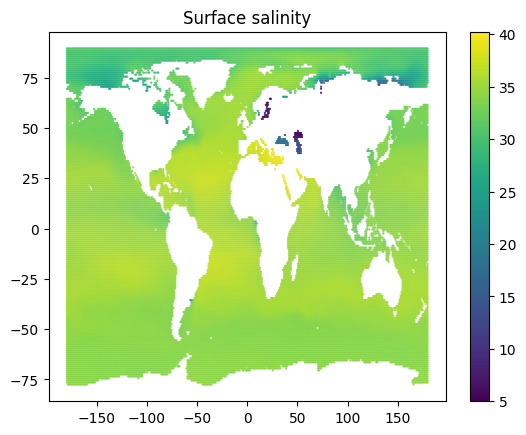

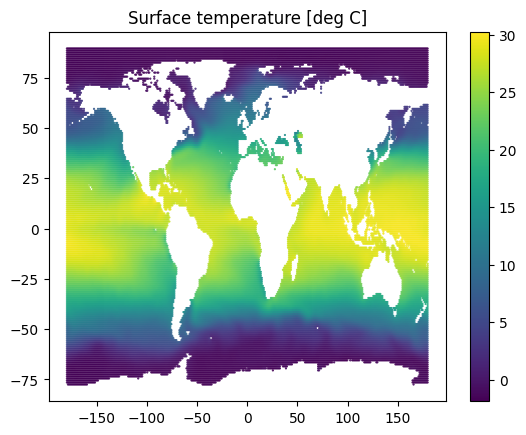

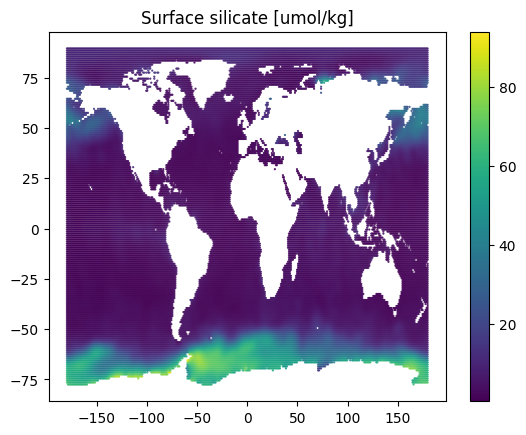

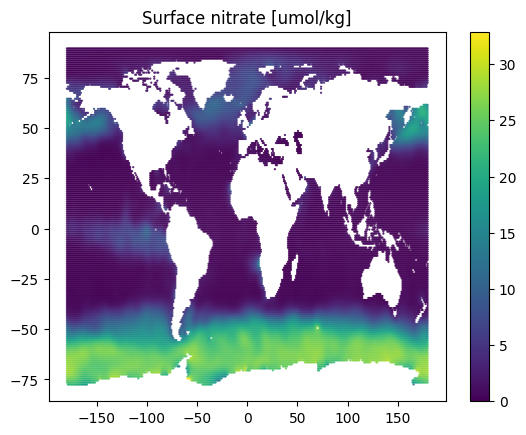

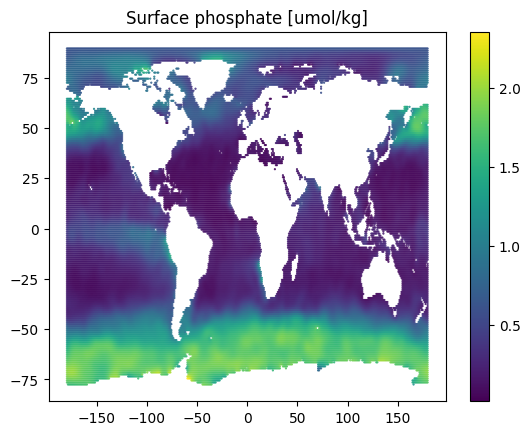

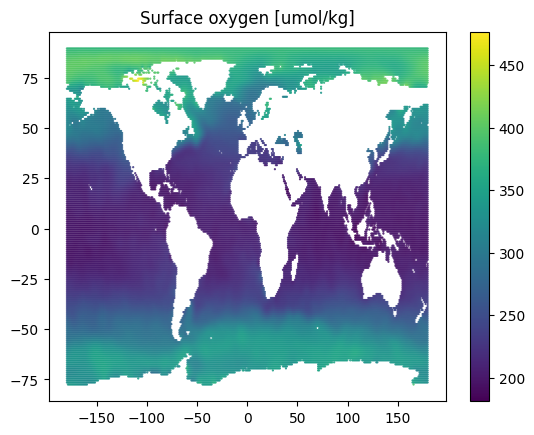

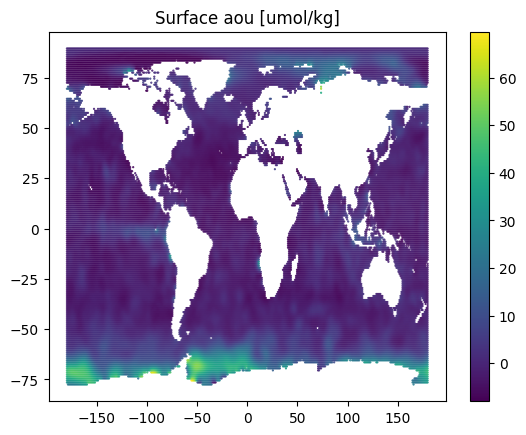

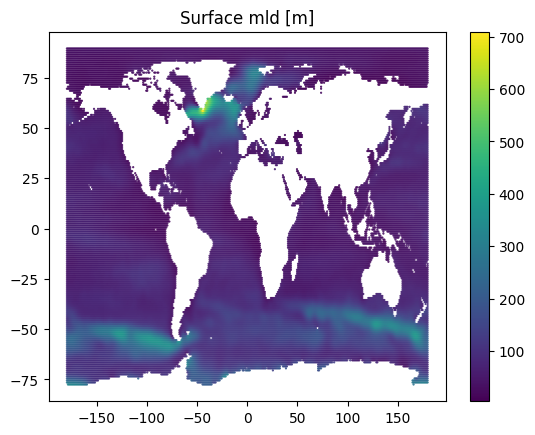

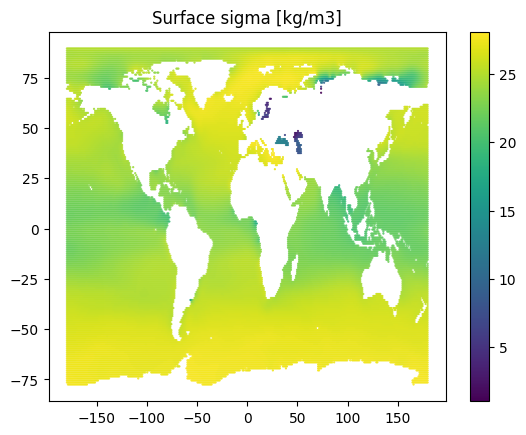

In [58]:
variables = [WOD_salinity, WOD_temp, WOD_silicate, WOD_nitrate, WOD_phosphate, WOD_oxygen, WOD_aou, WOD_mld, WOD_sigma]
titles = ['salinity', 'temperature [deg C]', 'silicate [umol/kg]', 'nitrate [umol/kg]', 'phosphate [umol/kg]', 'oxygen [umol/kg]', 'aou [umol/kg]', 'mld [m]', 'sigma [kg/m3]']

for i in range(0, len(variables)):
    plt.scatter(variables[i]['WOD_longitude [degrees_east]'], variables[i]['WOD_latitude [degrees_north]'], c=variables[i]['0'], s = 0.3)
    plt.title(f'Surface {titles[i]}')
    plt.colorbar()
    plt.show()

##### Chlorophyll-a

In [59]:
glo_bio = xr.open_dataset('../../Data/cmems_mod_glo_bgc_0.25.nc')
glo_bio

<xarray.Dataset>
Dimensions:    (depth: 1, time: 156, latitude: 681, longitude: 1440)
Coordinates:
  * depth      (depth) float32 0.5058
  * latitude   (latitude) float32 -80.0 -79.75 -79.5 -79.25 ... 89.5 89.75 90.0
  * time       (time) datetime64[ns] 2005-01-16T12:00:00 ... 2017-12-16T12:00:00
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
Data variables:
    chl        (time, depth, latitude, longitude) float32 ...
Attributes: (12/17)
    product:                       GLOBAL_REANALYSIS_BIO_001_029
    producer:                      CMEMS - Global Monitoring and Forecasting ...
    title:                         Monthly mean fields for product GLOBAL_REA...
    area:                          GLOBAL
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    Conventions:                   CF-1.6
    ...                            ...
    dataset:                       global-reanalysis-bio-001-029-monthly
    institution:                   Mercator Ocean
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    _CoordSysBuilder:              ucar.nc2.dataset.conv.CF1Convention
    comment:                       
    history:                       Data extracted from dataset http://localho...

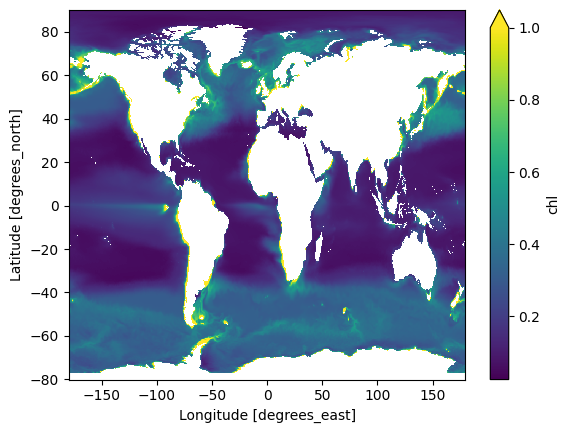

In [60]:
chl_a = glo_bio['chl']
annual_chl = chl_a.mean(dim="time")
annual_chl = annual_chl.mean(dim="depth")
annual_chl.plot(x="longitude", vmax = 1)

In [61]:
lats_xr = xr.DataArray(WOD_pb_lats, dims=['location'])
lons_xr = xr.DataArray(WOD_pb_lons, dims=['location'])

WOD_pb_dataset['Chlorophyll-a'] = annual_chl.sel(latitude = lats_xr, longitude = lons_xr, method = 'nearest')

/tmp/ipykernel_750919/1859378764.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WOD_pb_dataset['Chlorophyll-a'] = annual_chl.sel(latitude = lats_xr, longitude = lons_xr, method = 'nearest')


##### Black carbon

In [62]:
cams = xr.open_dataset('../../Data/CAMS_global_2005-2017.nc')
cams

<xarray.Dataset>
Dimensions:    (longitude: 480, latitude: 241, time: 156)
Coordinates:
  * longitude  (longitude) float32 0.0 0.75 1.5 2.25 ... 357.0 357.8 358.5 359.2
  * latitude   (latitude) float32 90.0 89.25 88.5 87.75 ... -88.5 -89.25 -90.0
  * time       (time) datetime64[ns] 2005-01-01 2005-02-01 ... 2017-12-01
Data variables:
    bcaod550   (time, latitude, longitude) float32 ...
    duaod550   (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2024-07-04 08:44:37 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [63]:
cams = cams.assign_coords(longitude=(((cams.longitude + 180) % 360) - 180)).sortby('longitude')

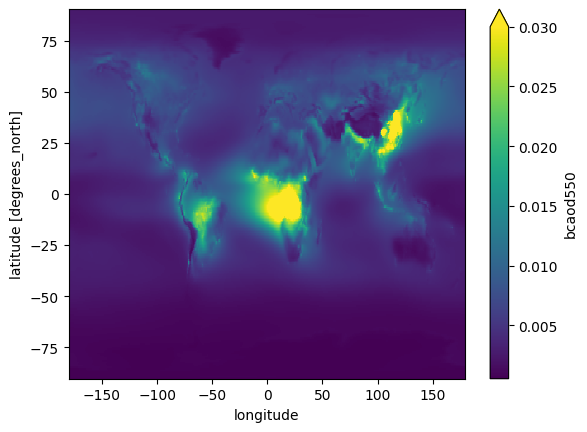

In [64]:
bc = cams['bcaod550']
annual_bc = bc.mean(dim="time")
annual_bc.plot(x="longitude", vmax = 0.03)

In [65]:
lats_xr = xr.DataArray(WOD_pb_lats, dims=['location'])
lons_xr = xr.DataArray(WOD_pb_lons, dims=['location'])

WOD_pb_dataset['Black Carbon AOD'] = annual_bc.sel(latitude = lats_xr, longitude = lons_xr, method = 'nearest')

/tmp/ipykernel_750919/88990101.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WOD_pb_dataset['Black Carbon AOD'] = annual_bc.sel(latitude = lats_xr, longitude = lons_xr, method = 'nearest')


##### Dust

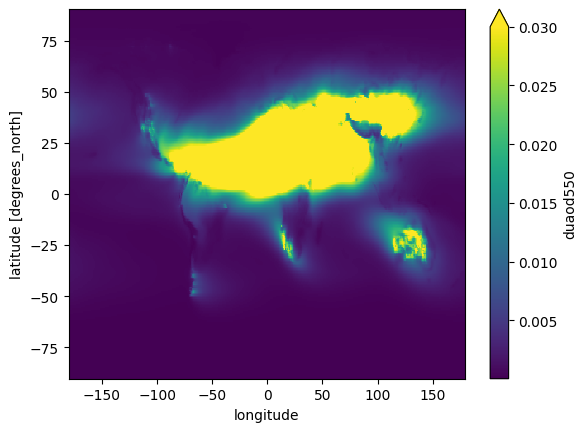

In [66]:
dust = cams['duaod550']
annual_dust = dust.mean(dim="time")
annual_dust.plot(x="longitude", vmax = 0.03)

In [67]:
lats_xr = xr.DataArray(WOD_pb_lats, dims=['location'])
lons_xr = xr.DataArray(WOD_pb_lons, dims=['location'])

WOD_pb_dataset['Dust AOD'] = annual_dust.sel(latitude = lats_xr, longitude = lons_xr, method = 'nearest')

/tmp/ipykernel_750919/529110604.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WOD_pb_dataset['Dust AOD'] = annual_dust.sel(latitude = lats_xr, longitude = lons_xr, method = 'nearest')


### Set distance from bottom depth

In [68]:
WOD_pb_dataset['Bottom_distance'] = round(WOD_pb_dataset['Bot. Depth [m]'] - WOD_pb_dataset['WOD_depth'])

/tmp/ipykernel_750919/3007584395.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WOD_pb_dataset['Bottom_distance'] = round(WOD_pb_dataset['Bot. Depth [m]'] - WOD_pb_dataset['WOD_depth'])


<Axes: >

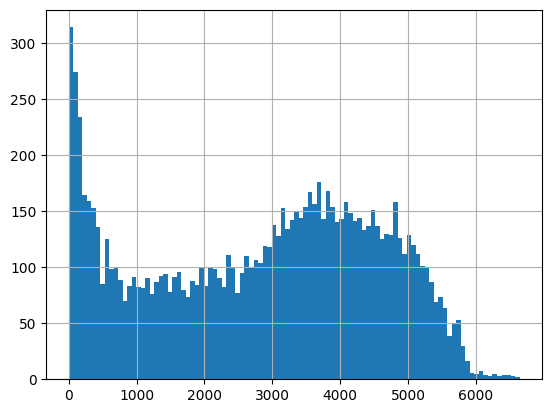

In [69]:
WOD_pb_dataset['Bottom_distance'].hist(bins = 100)

### Drop duplicate predictors (WOD & GEOTRACES dataset) - keep WOD

In [70]:
WOD_pb_dataset.drop(['Latitude [degrees_north]', 'Longitude [degrees_east]', 'CTDTMP_T_VALUE_SENSOR [deg C]', 'CTDSAL_D_CONC_SENSOR [pss-78]', 'Bot. Depth [m]'], inplace=True, axis=1)


/tmp/ipykernel_750919/1071665013.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WOD_pb_dataset.drop(['Latitude [degrees_north]', 'Longitude [degrees_east]', 'CTDTMP_T_VALUE_SENSOR [deg C]', 'CTDSAL_D_CONC_SENSOR [pss-78]', 'Bot. Depth [m]'], inplace=True, axis=1)


### Drop all rows that have at least one NaN (missing data from ocean climatologies)

In [71]:
WOD_pb_dataset.dropna(subset = ['Salinity', 'MLD', 'Chlorophyll-a'], inplace=True) #Salinity representative of ocean mask for all other WOD datasets
WOD_pb_dataset

/tmp/ipykernel_750919/2709942108.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WOD_pb_dataset.dropna(subset = ['Salinity', 'MLD', 'Chlorophyll-a'], inplace=True) #Salinity representative of ocean mask for all other WOD datasets


,Cruise,WOD_depth,WOD_latitude [degrees_north],WOD_longitude [degrees_east],Pb_CONC [pmol/kg],Pb_206_207,Pb_208_207,Ocean_basin,Salinity,Temperature,Silicate,Nitrate,Phosphate,Oxygen,AOU,MLD,Sigma,Chlorophyll-a,Black Carbon AOD,Dust AOD,Bottom_distance
48,GA01,15,40.5,-12.5,30.100000,1.1798,2.4483,Atlantic,35.985,17.068,0.916,0.990,0.125,246.679,-5.164,86.271,26.381,0.161568,0.005372,0.012002,5243.0
49,GA01,25,40.5,-12.5,28.500000,1.1771,2.4479,Atlantic,35.984,16.883,0.967,1.087,0.130,247.044,-4.812,86.271,26.476,0.161568,0.005372,0.012002,5233.0
50,GA01,55,40.5,-12.5,27.299999,1.1781,2.4495,Atlantic,35.965,15.424,1.071,1.952,0.165,246.471,-0.496,86.271,26.906,0.161568,0.005372,0.012002,5203.0
53,GA01,200,40.5,-12.5,32.000000,1.1871,2.4515,Atlantic,35.799,13.013,2.721,7.936,0.456,230.087,28.816,86.271,27.933,0.161568,0.005372,0.012002,5058.0
54,GA01,500,40.5,-12.5,34.799999,1.1789,2.4514,Atlantic,35.634,11.463,5.656,13.444,0.781,207.979,59.479,86.271,29.467,0.161568,0.005372,0.012002,4758.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13575,GP06-Chen2023,200,29.5,130.5,53.977687,1.1648,2.4493,Pacific,34.725,18.135,8.817,4.981,0.411,191.026,43.117,62.998,25.955,0.298270,0.011949,0.018216,2867.0
13576,GP06-Chen2023,300,29.5,130.5,56.898171,1.1641,2.4493,Pacific,34.618,15.491,15.280,8.925,0.719,178.790,67.295,62.998,26.933,0.298270,0.011949,0.018216,2767.0
13577,GP06-Chen2023,150,29.5,130.5,45.360875,NaN,NaN,Pacific,34.752,19.751,6.504,2.939,0.287,197.577,30.128,62.998,25.364,0.298270,0.011949,0.018216,2917.0
13578,GP06-Chen2023,500,29.5,130.5,39.556952,NaN,NaN,Pacific,34.361,10.335,38.951,20.145,1.467,145.696,126.283,62.998,28.667,0.298270,0.011949,0.018216,2567.0


In [72]:
WOD_pb_dataset.dropna(subset = ['Bottom_distance'], inplace=True)

/tmp/ipykernel_750919/2907797236.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WOD_pb_dataset.dropna(subset = ['Bottom_distance'], inplace=True)


In [73]:
WOD_pb_dataset

,Cruise,WOD_depth,WOD_latitude [degrees_north],WOD_longitude [degrees_east],Pb_CONC [pmol/kg],Pb_206_207,Pb_208_207,Ocean_basin,Salinity,Temperature,Silicate,Nitrate,Phosphate,Oxygen,AOU,MLD,Sigma,Chlorophyll-a,Black Carbon AOD,Dust AOD,Bottom_distance
48,GA01,15,40.5,-12.5,30.100000,1.1798,2.4483,Atlantic,35.985,17.068,0.916,0.990,0.125,246.679,-5.164,86.271,26.381,0.161568,0.005372,0.012002,5243.0
49,GA01,25,40.5,-12.5,28.500000,1.1771,2.4479,Atlantic,35.984,16.883,0.967,1.087,0.130,247.044,-4.812,86.271,26.476,0.161568,0.005372,0.012002,5233.0
50,GA01,55,40.5,-12.5,27.299999,1.1781,2.4495,Atlantic,35.965,15.424,1.071,1.952,0.165,246.471,-0.496,86.271,26.906,0.161568,0.005372,0.012002,5203.0
53,GA01,200,40.5,-12.5,32.000000,1.1871,2.4515,Atlantic,35.799,13.013,2.721,7.936,0.456,230.087,28.816,86.271,27.933,0.161568,0.005372,0.012002,5058.0
54,GA01,500,40.5,-12.5,34.799999,1.1789,2.4514,Atlantic,35.634,11.463,5.656,13.444,0.781,207.979,59.479,86.271,29.467,0.161568,0.005372,0.012002,4758.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13575,GP06-Chen2023,200,29.5,130.5,53.977687,1.1648,2.4493,Pacific,34.725,18.135,8.817,4.981,0.411,191.026,43.117,62.998,25.955,0.298270,0.011949,0.018216,2867.0
13576,GP06-Chen2023,300,29.5,130.5,56.898171,1.1641,2.4493,Pacific,34.618,15.491,15.280,8.925,0.719,178.790,67.295,62.998,26.933,0.298270,0.011949,0.018216,2767.0
13577,GP06-Chen2023,150,29.5,130.5,45.360875,NaN,NaN,Pacific,34.752,19.751,6.504,2.939,0.287,197.577,30.128,62.998,25.364,0.298270,0.011949,0.018216,2917.0
13578,GP06-Chen2023,500,29.5,130.5,39.556952,NaN,NaN,Pacific,34.361,10.335,38.951,20.145,1.467,145.696,126.283,62.998,28.667,0.298270,0.011949,0.018216,2567.0


##### Drop samples with unusually high Pb concentration values

In [74]:
samples_to_drop = [
    {'cruise': 'GIpr06', 'depth': 60, 'lat': -61.5, 'lon': 93.5, 'Pb_conc': 163.249374},
    {'cruise': 'GIpr06', 'depth': 250, 'lat': -61.5, 'lon': 93.5, 'Pb_conc': 81.27401},
    {'cruise': 'GIpr06', 'depth': 300, 'lat': -61.5, 'lon': 93.5, 'Pb_conc': 81.272537},
    {'cruise': 'GIPY02', 'depth': 25, 'lat': -46.5, 'lon': 140.5, 'Pb_conc': 125.268295},
    {'cruise': 'GIPY02', 'depth': 125, 'lat': -44.5, 'lon': 143.5, 'Pb_conc': 115.512192},
    {'cruise': 'GIPY02', 'depth': 25, 'lat': -44.5, 'lon': 143.5, 'Pb_conc': 103.609756},
    {'cruise': 'GIPY02', 'depth': 75, 'lat': -44.5, 'lon': 143.5, 'Pb_conc': 92.585365},
    {'cruise': 'GIPY02', 'depth': 125, 'lat': -46.5, 'lon': 140.5, 'Pb_conc': 83.804878}
    ]

indices_to_drop = []

for sample in samples_to_drop:
    condition = ((WOD_pb_dataset['Cruise'] == sample['cruise']) & (WOD_pb_dataset['WOD_depth'] == sample['depth']) & (WOD_pb_dataset['WOD_latitude [degrees_north]'] == sample['lat']) & (WOD_pb_dataset['WOD_longitude [degrees_east]'] == sample['lon']) & (WOD_pb_dataset['Pb_CONC [pmol/kg]'] == sample['Pb_conc']))
    indices_to_drop.extend(WOD_pb_dataset[condition].index.tolist())

In [75]:
WOD_pb_dataset.drop(index=indices_to_drop, inplace=True)

WOD_pb_dataset

/tmp/ipykernel_750919/61990068.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WOD_pb_dataset.drop(index=indices_to_drop, inplace=True)


,Cruise,WOD_depth,WOD_latitude [degrees_north],WOD_longitude [degrees_east],Pb_CONC [pmol/kg],Pb_206_207,Pb_208_207,Ocean_basin,Salinity,Temperature,Silicate,Nitrate,Phosphate,Oxygen,AOU,MLD,Sigma,Chlorophyll-a,Black Carbon AOD,Dust AOD,Bottom_distance
48,GA01,15,40.5,-12.5,30.100000,1.1798,2.4483,Atlantic,35.985,17.068,0.916,0.990,0.125,246.679,-5.164,86.271,26.381,0.161568,0.005372,0.012002,5243.0
49,GA01,25,40.5,-12.5,28.500000,1.1771,2.4479,Atlantic,35.984,16.883,0.967,1.087,0.130,247.044,-4.812,86.271,26.476,0.161568,0.005372,0.012002,5233.0
50,GA01,55,40.5,-12.5,27.299999,1.1781,2.4495,Atlantic,35.965,15.424,1.071,1.952,0.165,246.471,-0.496,86.271,26.906,0.161568,0.005372,0.012002,5203.0
53,GA01,200,40.5,-12.5,32.000000,1.1871,2.4515,Atlantic,35.799,13.013,2.721,7.936,0.456,230.087,28.816,86.271,27.933,0.161568,0.005372,0.012002,5058.0
54,GA01,500,40.5,-12.5,34.799999,1.1789,2.4514,Atlantic,35.634,11.463,5.656,13.444,0.781,207.979,59.479,86.271,29.467,0.161568,0.005372,0.012002,4758.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13575,GP06-Chen2023,200,29.5,130.5,53.977687,1.1648,2.4493,Pacific,34.725,18.135,8.817,4.981,0.411,191.026,43.117,62.998,25.955,0.298270,0.011949,0.018216,2867.0
13576,GP06-Chen2023,300,29.5,130.5,56.898171,1.1641,2.4493,Pacific,34.618,15.491,15.280,8.925,0.719,178.790,67.295,62.998,26.933,0.298270,0.011949,0.018216,2767.0
13577,GP06-Chen2023,150,29.5,130.5,45.360875,NaN,NaN,Pacific,34.752,19.751,6.504,2.939,0.287,197.577,30.128,62.998,25.364,0.298270,0.011949,0.018216,2917.0
13578,GP06-Chen2023,500,29.5,130.5,39.556952,NaN,NaN,Pacific,34.361,10.335,38.951,20.145,1.467,145.696,126.283,62.998,28.667,0.298270,0.011949,0.018216,2567.0


## <strong style = "color:green"> Save final dataset </strong>

In [76]:
WOD_pb_dataset.to_csv('../../Data/WOD_Pb_dataset-cleanedSOPbconc.csv', index = False)